In [27]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
from scipy      import optimize
import skimage
import matplotlib.pyplot as plt
import imageio
import pylab
from glob import glob
import sys
import itk
from itkwidgets import view
from itk import TubeTK as ttk

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_IO import *

In [28]:
data_paths = sorted(glob("../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding/*.m??"))

In [29]:
data_paths

['../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\Image_262499828648_clean.mp4',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_1083297968960_clean.mp4',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_1087766719219_clean.mp4',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_1394469579519_clean.mp4',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_1404802450036_clean.mp4',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_1543571117118_clean.mp4',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_1749559540112_clean.mp4',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_1884162273498_clean.mov',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_1895283541879_clean.mov',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_2418161753608_clean.mp4',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\image_2454526567135_CLEAN.mp4',
 '../../Data/TrainingData/AR-UNet\\BAMC-PTXNoSliding\\i

In [30]:
num_vid = len(data_paths)

min_frame = 2
max_frame = 4
num_frame = max_frame-min_frame

height,width = shape_video(data_paths[0])
vid_shape = (height,width)
print(vid_shape)

(1080, 1920)


In [53]:
ims = np.zeros((num_vid,vid_shape[0],vid_shape[1]), dtype = np.float32)

# Compute an image that is the mean of the first num_vid frames
for i in [1,7]:#range(num_vid):
    vid = load_video(data_paths[i])
    img = np.squeeze(np.max(vid[min_frame:max_frame,:,:],axis=0))
    ims[i] = img-1

Using non-standard frame rate 10240/512
Using non-standard frame rate 10240/512


In [58]:
view(ims[7])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF2; pro…

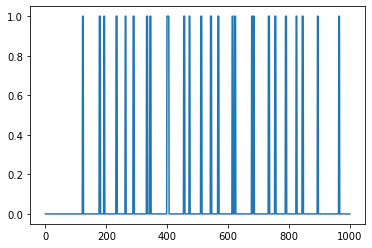

In [59]:
y_min = 80
y_max = 1080
imt = (ims[1,y_min:y_max,10:12]/200).astype(int)
mid1 = np.mean(imt,axis=1)
imt = (ims[7,y_min:y_max,10:12]/200).astype(int)
mid2 = np.mean(imt,axis=1)
plt.plot(mid1+mid2)

In [60]:
def get_ruler_points_C52(im):
    """ Find points along ruler on left side of image """
    y_min = 80
    y_max = 1080
    min_x = 10
    max_x = 12
    mid = np.mean((im[y_min:y_max,min_x:max_x]/200).astype(int),axis=1)
    y = np.flatnonzero(mid)
    return y

In [66]:
def get_depth_and_zoom_C52(im):
    y = get_ruler_points_C52(im)

    avg = 0
    count = 0
    yCenters = []
    for j in range(y.size-1):
        avg += y[j]
        count += 1
        if(y[j+1]-y[j]>5):
            avg /= count
            yCenters.append(avg)
            avg = 0
            count = 0
    avg += y[y.size-1]
    count += 1
    avg /= count
    yCenters.append(avg)
    avg = 0
    for j in range(len(yCenters)-1):
        avg += yCenters[j+1]-yCenters[j]
    avg /= len(yCenters)-1    
    
    tic_num = len(yCenters)
    tic_min = yCenters[0]
    tic_max = yCenters[len(yCenters)-1]
    tic_diff = avg
    if(tic_num==17):
        tic_depth = 16
        tic_scale = tic_diff/54.4375
    elif(tic_num==13):
        tic_depth = 12
        tic_scale = tic_diff/55.5
    elif(tic_num==11):
        tic_depth = 5
        tic_scale = tic_diff/38.0
    else:
        print("ERROR: Unknown image depth!")
        print("   Num tics = ", tic_num, "   diff = ", tic_diff)
        
    return tic_depth,tic_scale,tic_num,tic_min,tic_max,tic_diff

In [68]:
vid_tic_num = np.zeros(num_vid)
vid_tic_min = np.zeros(num_vid)
vid_tic_max = np.zeros(num_vid)
vid_tic_diff = np.zeros(num_vid)
vid_tic_depth = np.zeros(num_vid)
vid_tic_scale = np.zeros(num_vid)
im_mask_depth = [5,12,16]
im_mask = np.zeros((len(im_mask_depth), vid_shape[0],vid_shape[1]), dtype = np.float32)
for i in [1,7]:#range(num_vid):
    print(i, data_paths[i])
    tic_depth, tic_scale, tic_num, tic_min, tic_max, tic_diff = get_depth_and_zoom_C52(ims[i])
    vid_tic_num[i] = tic_num
    vid_tic_min[i] = tic_min
    vid_tic_max[i] = tic_max
    vid_tic_diff[i] = tic_diff
    vid_tic_depth[i] = tic_depth
    vid_tic_scale[i] = tic_scale
    print("   ", vid_tic_depth[i], "cm @ scale = ", vid_tic_scale[i])
    for j in range(3):
        if(vid_tic_depth[i]==im_mask_depth[j] and vid_tic_scale[i]==1):
            im_mask[j]+=ims[i]


1 ../../Data/TrainingData/AR-UNet\BAMC-PTXNoSliding\image_1083297968960_clean.mp4
    12.0 cm @ scale =  1.0
7 ../../Data/TrainingData/AR-UNet\BAMC-PTXNoSliding\image_1884162273498_clean.mov
    12.0 cm @ scale =  1.2627627627627627


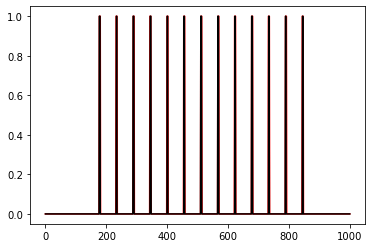

In [112]:
imt = (ims[1,y_min:y_max,10:12]/200).astype(int)
mid1 = np.mean(imt,axis=1)
imt = (ims[7,y_min:y_max,10:12]/200).astype(int)
mid2 = np.mean(imt,axis=1)
mid3 = np.zeros(len(mid1))
for i in range(len(mid2)):
    x = 80+i
    z = 1.2626262627
    offset = 62
    xx = x/z - 62 + 80
    if(xx>=0 and xx<len(mid1)):
        mid3[int(xx)] = mid2[i]
plt.plot(mid1,'r')
plt.plot(mid3,'k')


In [69]:
for i in range(3):
    img = itk.GetImageFromArray(im_mask[i])
    imMath = ttk.ImageMath.New(img)
    imMath.Threshold(-1,0,0,1)
    imMath.Dilate(15,1,0)
    imMath.Erode(17,1,0)
    imMath.Dilate(2,1,0)
    imMath.IntensityWindow(0,1,0,255)
    itk.imwrite(imMath.GetOutputUChar(), "EstimatedMask_Depth"+str(im_mask_depth[i])+".png")
